> 本文是机器之心GitHub实现项目，我们根据谷歌的Transformer原论文与Harvard NLP所实现的代码学习构建了一个神经机器翻译系统。因此，我们希望各位读者也能根据这篇文章了解Transformer的架构，并动手实现一个神经机器翻译系统。


自去年6月份“Attention is All You Need”发表以来，Transformer受到越来越多的关注。它除了能显著提升翻译质量，同时还为很多NLP任务提供了新的架构。这篇论文放弃了传统基于RNN或CNN的深度架构，并只保留了注意力（Attentaion）机制，虽然原论文在这一方面描述地比较清楚，但要正确地实现这样的新型架构可能非常困难。

在这篇文章中，我们从注意力机制到神经机器翻译系统解释了实现Transformer的架构与代码，并借助这些实现理解原论文。机器之心整理了整个实现，并根据我们对原论文与实现的理解添加一些解释。整个文章就是一个可运行的Jupyter Notebook，读者可直接在Colaboratory中阅读文章与运行代码。

- 机器之心实现地址：https://github.com/jiqizhixin/ML-Tutorial-Experiment 
- 原实现地址：https://github.com/harvardnlp/annotated-transformer

本文所有的代码都可以在谷歌Colab 上运行，且读者也可以在GitHub中下载全部的代码在本地运行。这篇文章非常适合于研究者与感兴趣的开发者，代码很大程度上都依赖于OpenNMT库。对于服务端的实现，请查看Tensor2Tensor （tensorflow）和 Sockeye（mxnet）。

在运行模型前，我们需要确保有对应的环境。如果在本地运行，那么需要确保以下基本库的导入不会报错，若在Colab上运行，那么首先需要运行以下第一个pip语句安装对应的包。Colab的环境配置非常简单，一般只需要使用conda或pip命令就能完成。此外，Colab语句前面加上“!”表示这是命令行，而不加感叹号则表示这个代码框是Python代码。


In [0]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext 

    100% |████████████████████████████████| 592.3MB 52.6MB/s 
    31% |██████████▎                     | 5.6MB 35.0MB/s eta 0:00:01    100% |████████████████████████████████| 17.5MB 79kB/s 
    100% |████████████████████████████████| 51kB 8.1MB/s 
    100% |████████████████████████████████| 51kB 7.7MB/s 
    100% |████████████████████████████████| 890kB 1.3MB/s 
    100% |████████████████████████████████| 51kB 7.6MB/s 
    100% |████████████████████████████████| 92kB 7.7MB/s 
    100% |████████████████████████████████| 604kB 2.1MB/s 
    100% |████████████████████████████████| 1.2MB 1.0MB/s 
    100% |████████████████████████████████| 194kB 5.6MB/s 
    100% |████████████████████████████████| 61kB 9.1MB/s 
    100% |████████████████████████████████| 389kB 2.5MB/s 
    100% |████████████████████████████████| 51kB 4.2MB/s 
  Running setup.py bdist_wheel for spacy ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ |

In [0]:
# Standard PyTorch imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy
from torch.autograd import Variable

# For plots
%matplotlib inline
import matplotlib.pyplot as plt


* Table of Contents                               
{:toc}      

# 引言

减少序列计算的任务目标构成了 Extended Neural GPU、ByteNet 和 ConvS2S 的基础，它们都是使用卷积神经网络作为基本构建块，因而能对所有输入与输出位置的隐藏表征执行并行计算。在这些模型中，两个任意输入与输出位置的信号关联所需要的运算数量与它们的位置距离成正比，对于 ConvS2S 为线性增长，对于ByteNet 为对数增长。这种现象使得学习较远位置的依赖关系非常困难。而在 Transformer 中，这种成本会减少到一个固定的运算数量，尽管平均注意力位置加权会减少有效表征力，但使用 Multi-Head Attention 注意力机制可以抵消这种成本。

自注意力（Self-attention），有时也称为内部注意力，它是一种涉及单序列不同位置的注意力机制，并能计算序列的表征。自注意力在多种任务中都有非常成功的应用，例如阅读理解、摘要概括、文字蕴含和语句表征等。自注意力这种在序列内部执行 Attention 的方法可以视为搜索序列内部的隐藏关系，这种内部关系对于翻译以及序列任务的性能非常重要。

然而就我们所知道的，Transformer 是第一种完全依赖于自注意力以计算输入与输出表征的方法，这意味着它没有使用序列对齐的RNN或卷积网络。从 Transformer 的结构就可以看出，它并没有使用深度网络抽取序列特征，顶多使用几个线性变换对特征进行变换。

本文主要从模型架构、训练配置和两个实际翻译模型开始介绍 Ashish Vaswani 等人的原论文与 Harvard NLP 团队实现的代码。在模型架构中，我们将讨论编码器、解码器、注意力机制以及位置编码等关键组成部分，而训练配置将讨论如何抽取批量数据、设定训练循环、选择最优化方法和正则化器等。最后我们将跟随Alexander Rush 等人的实现训练两个神经机器翻译系统，其中一个仅使用简单的合成数据，而另一个则是真实的 IWSLT 德语-英语翻译数据集。


# 模型架构

大多数神经序列模型都使用编码器-解码器框架，其中编码器将表征符号的输入序列 $(x_1, …, x_n)$ 映射到连续表征 $z=(z_1, …, z_n)$。给定中间变量 $z$，解码器将会生成一个输出序列 $(y_1,…,y_m)$。在每一个时间步上，模型都是自回归的（auto-regressive），当生成序列中的下一个元素时，先前生成的元素会作为输入。

以下展示了一个标准的编码器-解码器框架，EncoderDecoder 类定义了先编码后解码的过程，例如先将英文序列编码为一个隐向量，在基于这个中间表征解码为中文序列。


In [0]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base model for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        memory = self.encoder(self.src_embed(src), src_mask)
        output = self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)
        return output

Transformer 的整体架构也采用了这种编码器-解码器的框架，它使用了多层自注意力机制和层级归一化，编码器和解码器都会使用全连接层和残差连接。Transformer 的整体结构如下图所示：

<img src="http://p598yuf6e.bkt.clouddn.com/transformer/trimage%20%281%29.png" width=400px>

## 编码器与解码器堆栈   

### 编码器

编码器由相同的6个模块堆叠而成，每一个模块都有两个子层级构成。其中第一个子层级是Multi-Head自注意机制，其中自注意力表示输入和输出序列都是同一条。第二个子层级采用了全连接网络，主要作用在于注意子层级的特征。此外，每一个子层级都会添加一个残差连接和层级归一化。

以下定义了编码器的主体框架，在Encoder类中，每一个layer表示一个编码器模块，这个编码器模块由两个子层级组成。layer函数的输出表示经过层级归一化的编码器模块输出，通过For循环堆叠层级就能完成整个编码器的构建。


In [0]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [0]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

如编码器的结构图所示，每个子层级都会会添加一个残差连接，并随后传入层级归一化。上面构建的主体架构也调用了层级归一化函数，以下代码展示了层级归一化的定义。 

In [0]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

层级归一化可以通过修正每一层内激活值的均值与方差而大大减少协方差偏离问题。简单来说，一个层级的均值可以通过计算该层所有神经元激活值的平均值而得出，然后再根据均值计算该层所有神经元激活值的方差。最后根据均值与方差，我们可以对这一层所有输出值进行归一化。

如上LayerNorm类所示，我们首先需要使用方法mean求输入x最后一个维度的均值，keepdim 为真表示求均值后的维度保持不变，并且均值会广播操作到对应的维度。同样使用std方法计算标准差后，该层所有激活值分别减去均值再除以标准差就能实现归一化，分母加上一个小值eps可以防止分母为零。

因此，每一个子层的输出为 LayerNorm(x+Sublayer(x))，其中Sublayer(x)表示由子层本身实现的函数。我们应用Dropout将每一个子层的输出随机失活，这一过程会在加上子层输入和执行归一化之前完成。

以下定义了残差连接，我们会在投入层级归一化函数前将子层级的输入与输出相加。为了使用这些残差连接，模型中所有的子层和嵌入层的输出维度都是 d_model=512。


In [0]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity we apply the norm first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer function that maintains the same size."
        return x + self.dropout(sublayer(self.norm(x)))

在上述代码定义中，x表示上一层添加了残差连接的输出，这一层添加了残差连接的输出需要将x执行层级归一化，然后馈送到Multi-Head Attention 层或全连接层，添加Dropout操作后可作为这一子层级的输出。最后将该子层的输出向量与输入向量相加得到下一层的输入。

编码器每个模块有两个子层，第一个为multi-head自注意力层，第二个为简单的逐位置全连接前馈网络。以下的EncoderLayer类定义了一个编码器模块的过程。


In [0]:
class EncoderLayer(nn.Module):
    "Encoder is made up of two sublayers, self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

以上代码叠加了自注意力层与全连接层，其中Multi-Head Attention 机制的输入Query、Key和Value都为x就表示自注意力。

### 解码器

解码器也由相同的6个模块堆叠而成，每一个解码器模块都有三个子层组成，每一个子层同样会加上残差连接与层级归一化运算。第一个和第三个子层分别与编码器的Multi-Head自注意力层和全连接层相同，而第二个子层所采用的Multi-Head Attention 机制使用编码器的输出作为Key和Value，采用解码模块第一个子层的输出作为Query。

我们同样需要修正编码器堆栈中的自注意力子层，以防止当前位置注意到后续序列位置，这一修正可通过掩码实现。以下的解码器的主体堆叠结构和编码器相似，只需要简单地堆叠解码器模块就能完成。


In [0]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

以下展示了一个解码器模块的架构，第一个Multi-Head Attention 机制的三个输入都是x，因此它是自注意力。第二个Multi-Head注意力机制输入的Key和Value是编码器的输出memory，输入的Query是上一个子层的输出x。最后在叠加一个全连接网络以完成一个编码器模块的构建。 

In [0]:
class DecoderLayer(nn.Module):
    "Decoder is made up of three sublayers, self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

对于序列建模来说，模型应该只能查看有限的序列信息。例如在时间步i，模型能读取整个输入序列，但只能查看时间步i及之前的序列信息。对于Transformer的解码器来说，它会输入整个目标序列，且注意力机制会注意到整个目标序列各个位置的信息，因此我们需要限制注意力机制能看到的信息。

如上所述，Transformer在注意力机制中使用subsequent_mask函数以避免当前位置注意到后面位置的信息。因为输出词嵌入是位置的一个偏移，因此我们可以确保位置 i 的预测仅取决于在位置i之前的已知输出。


In [0]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

以下为注意力掩码的可视化，其中每一行为一个词，每一列则表示一个位置。下图展示了每一个词允许查看的位置，训练中词是不能注意到未来词的。

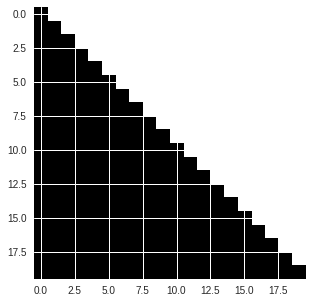

In [0]:
# The attention mask shows the position each tgt word (row) is allowed to look at (column).
# Words are blocked for attending to future words during training. 
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

## 注意力机制

谷歌在原论文中展示了注意力机制的一般化定义，即它和RNN或CNN一样也是一种编码序列的方案。一个注意力函数可以描述为将 Query 与一组键值对（Key-Value）映射到输出，其中Query、Key、Value和输出都是向量。输出可以通过值的加权和而计算得出，其中分配到每一个值的权重可通过Query和对应Key的适应度函数（compatibility function）计算。

在翻译任务中，Query可以视为原语词向量序列，而Key和Value可以视为目标语词向量序列。一般的注意力机制可解释为计算Query和Key之间的相似性，并利用这种相似性确定Query和Value之间的注意力关系。

以下是点积注意力的结构示意图，我们称这种特殊的结构为“缩放点积注意力”。它的输入由维度是d_k的Query和Key组成，Value的维度是d_v。如下所示，我们会先计算Query和所有Key的点乘，并每一个都除上squre_root(d_k)以防止乘积结果过大，然后再馈送到Softmax函数以获得与Value对应的权重。根据这样的权重，我们就可以配置Value向量而得出最后的输出。
                                                                                                      
<img width="400px" src="http://p598yuf6e.bkt.clouddn.com/transformer/trimage%20%282%29.png">

在上图中，Q 和K的运算有一个可选的Mask过程。在编码器中，我们不需要使用它限制注意力模块所关注的序列信息。而在解码器中，我们需要它限制注意力模块只能注意到当前时间步及之前时间步的信息。这一个过程可以很简洁地表示为函数Attention(Q, K, V)。
Attention(Q, K, V) 函数在输入矩阵Q、K和V的情况下可计算Query序列与Value序列之间的注意力关系。其中Q的维度为 n×d_k，表示有n条维度为d_k的Query、K的维度为m×d_k、V的维度为m×d_v。这三个矩阵的乘积可得出n×d_v维的矩阵，它表示n条Query对应注意到的Value向量。


                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$                                                                                                                                                                                                        
                                                                                                                                                                     

上式中Q与K的点积会除上squre_root(d_k)以实现缩放。原论文作者发现，当每一条Query的维度d_k比较小时，点乘注意力和加性注意力的性能相似，但随着d_k的增大，加性注意力的性能会超过点乘注意力机制。不过点乘注意力有一个强大的属性，即它可以利用矩阵乘法的并行运算大大加快训练速度。

原论文作者认为点乘注意力效果不好的原因是在d_k比较大的情况下，乘积结果会非常大，因此会导致Softmax快速饱和并只能提供非常小的梯度来更新参数。所以他们采用了根号下d_k来缩小点乘结果，并防止Softmax函数饱和。

为了证明为什么点积的量级会变得很大，我们假设元素q和k都是均值为0、方差为1的独立随机变量，它们的点乘 $q⋅k=∑q_i*k_i$ 有 0 均值和 d_k 的方差。为了抵消这种影响，我们可以通过除上squre_root(d_k)以归一化点乘结果。

以下函数定义了一个标准的点乘注意力，该函数最终会返回匹配 Query 和 Key 的权重或概率 p_attn，以及最终注意力机制的输出序列。


In [0]:
def attention(query, key, value, mask=None, dropout=0.0):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    # (Dropout described below)
    p_attn = F.dropout(p_attn, p=dropout)
    return torch.matmul(p_attn, value), p_attn

在上述函数中，query 矩阵的列数即维度数 d_k。在计算点乘并缩放后，我们可以在最后一个维度执行 Softmax 函数以得到概率 p_attn。  

两个最常见的注意力函数是加性注意力（additive attention）和点乘（乘法）注意力。除了要除上缩放因子squre_root(d_k)，标准的点乘注意力与原论文中所采用的是相同的。加性注意力会使用单隐藏层的前馈网络计算适应度函数，它们在理论复杂度上是相似的。点积注意力在实践中更快速且参数空间更高效，因为它能通过高度优化的矩阵乘法库并行地计算。


## Multi-Head Attention  

下图展示了Transformer中所采用的Multi-head Attention结构，它其实就是多个点乘注意力并行地处理并最后将结果拼接在一起。一般而言，我们可以对三个输入矩阵Q、V、K分别进行h个不同的线性变换，然后分别将它们投入h个点乘注意力函数并拼接所有的输出结果。

<img width="400px" src="http://p598yuf6e.bkt.clouddn.com/transformer/trimage%20%284%29.png">


Multi-head Attention允许模型联合关注不同位置的不同表征子空间信息，我们可以理解为在参数不共享的情况下，多次执行点乘注意力。Multi-head Attention的表达如下所示：
   
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                             

其中W为对应线性变换的权重矩阵，Attention()就是上文所实现的点乘注意力函数。

在原论文和实现中，研究者使用了 h=8 个并行点乘注意力层而完成Multi-head Attention。对于每一个注意力层，原论文使用的维度是d_k=d_v=d_model/h=64。由于每一个并行注意力层的维度降低，总的计算成本和单个点乘注意力在全维度上的成本非常相近。

以下定义了Multi-head Attention模块，它实现了上图所示的结构：




In [0]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.p = dropout
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.p)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous().view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

在以上代码中，首先我们会取query的第一个维度作为批量样本数，然后再实现多个线性变换将d_model维的词嵌入向量压缩到d_k维的隐藏向量，变换后的矩阵将作为点乘注意力的输入。点乘注意力输出的矩阵将在最后一个维度拼接，即8个n×64维的矩阵拼接为n×512维的大矩阵，其中n为批量数。这样我们就将输出向量恢复为与词嵌入向量相等的维度。

前面我们已经了解到Transformer使用了大量的自注意力机制，即Attention(X, X, X )。简单而言，Transformer 使用自注意力代替RNN或CNN抽取序列特征。对于机器翻译任务而言，自注意力输入的Query、Key和Value都是相同的矩阵，那么Query和Key之间的运算就相当于计算输入序列内部的相似性，并根据这种相似性或权重注意到序列自身（Value）的内部联系。

这种内部联系可能是主语注意到谓语和宾语的信息或其它隐藏在句子内部的结构。Transformer在神经机器翻译和阅读理解等任务上的优秀性能，都证明序列内部结构的重要性。

Transformer以三种不同的方式使用 multi-head Attention 。首先在编码器到解码器的层级中，Query来源于前面解码器的输出，而记忆的Key与Value都来自编码器的输出。这允许解码器中的每一个位置都注意输入序列中的所有位置，因此它实际上模仿了序列到序列模型中典型的编码器-解码器注意力机制。

其次，编码器包含了自注意力层，且该层中的所有Value、Key和Query都是相同的输入矩阵，即编码器的前层输出。最后，解码器中的自注意力层允许解码器中的每一个位置都注意到包括当前位置的所有合法位置。这可以通过上文定义的Mask函数实现，从而防止产生左向信息流来保持自回归属性。


## 逐位置的前馈网络                                                                                                                                                                                                                                                                                                                                                           

为了注意子层，每一个编码器和解码器模块最后都包含一个全连接前馈网络，它独立且相同地应用于每一个位置。这个前馈网络包含两个线性变换和一个非线性激活函数，且在训练过程中我们可以在两层网络之间添加Dropout方法：

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                                                                         

如果我们将这两个全连接层级与残差连接和层级归一化结合，那么它就是每一个编码器与解码器模块最后所必须的子层。我们可以将这一子层表示为：

$LayerNorm(x + max(0, x*w1 + b1)w2 + b2)$

尽管线性变换在所有不同的位置上都相同，但在不同的层级中使用不同的参数，这种变换其实同样可以描述为核大小为1的两个卷积。输入和输出的维度 d_model=512，而内部层级的维度d_ff=2018。

如下所示，前馈网络的定义和常规的方法并没有什么区别，不过这个网络没有添加偏置项，且对第一个全连接的输出实现了Dropout以防止过拟合。


In [0]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        # Torch linears have a `b` by default. 
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## 词嵌入和Softmax

与其它序列模型相似，我们可以使用学得的词嵌入将输入和输出的词汇转换为维度等于d_model的向量。我们还可以使用一般的线性变换和Softmax函数将解码器的输出转化为预测下一个词汇的概率。在愿论文的模型中，两个嵌入层和pre-softmax线性变换的权重矩阵是共享的。在词嵌入层中，我们将所有权重都乘以 squre_root(d_model)。


In [0]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## 位置编码

位置编码是Transformer模型中最后一个需要注意的结构，它对使用注意力机制实现序列任务也是非常重要的部分。如上文所述，Transformer使用自注意力机制抽取序列的内部特征，但这种代替RNN或CNN抽取特征的方法有很大的局限性，即它不能捕捉序列的顺序。这样的模型即使能根据语境翻译出每一个词的意义，那也组不成完整的语句。

为了令模型能利用序列的顺序信息，我们必须植入一些关于词汇在序列中相对或绝对位置的信息。直观来说，如果语句中每一个词都有特定的位置，那么每一个词都可以使用向量编码位置信息。将这样的位置向量与词嵌入向量相结合，那么我们就为每一个词引入了一定的位置信息，注意力机制也就能分辨出不同位置的词。

谷歌研究者将“位置编码”添加到输入词嵌入中，位置编码有和词嵌入相同的维度d_model，每一个词的位置编码与词嵌入向量相加可得出这个词的最终编码。目前有很多种位置编码，包括通过学习和固定表达式构建的。

在这一项实验中，谷歌研究者使用不同频率的正弦和预先函数：

$$                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \\                                                                                                                                                                                                                                                                                                                                                                                                                                      
    PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})                                                                                                                                                                                                                                                                                                                                                                                                                                       
$$                                                                                                                                                                                                                                                        
其中pos为词的位置，i为位置编码向量的第i个元素。给定词的位置pos，我们可以将词映射到d_model维的位置向量，该向量第i个元素就由上面两个式子计算得出。也就是说，位置编码的每一个维度对应于正弦曲线，波长构成了从2π到10000⋅2π的等比数列。

上面构建了绝对位置的位置向量，但词的相对位置同样非常重要，这也就是谷歌研究者采用三角函数表征位置的精妙之处。正弦与余弦函数允许模型学习相对位置，这主要根据两个变换：sin(α+β)=sinα cosβ+cosα sinβ 以及 cos(α+β)=cosα cosβ−sinα sinβ。

对于词汇间固定的偏移量k，位置向量PE(pos+k)可以通过PE(pos)与PE(k)的组合表示，这也就表示了语言间的相对位置。

以下定义了位置编码，其中我们对词嵌入与位置编码向量的和使用Dropout，默认可令 $\_drop=0.1$。div_term 实现的是分母，而 pe[:, 0::2]表示第二个维度从0开始以间隔为2取值，即偶数。                      


In [0]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

以下将基于一个位置将不同的正弦曲线添加到位置编码向量中，曲线的频率和偏移量在每个维度上都不同。

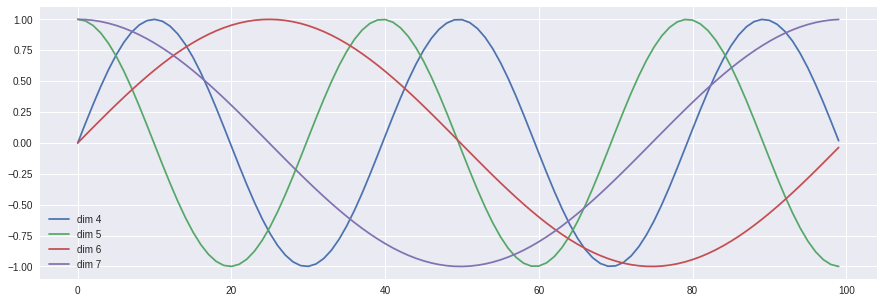

In [0]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

谷歌等研究者在原论文中表示他们同样对基于学习的位置编码进行了实验，并发现这两种方法会产生几乎相等的结果。所以按照性价比，他们还是选择了正弦曲线，因为它允许模型在训练中推断更长的序列。  

## 生成

In [0]:
class Generator(nn.Module):
    "Standard generation step. (Not described in the paper.)"
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## 模型整体
下面，我们定义了一个函数以构建模型的整个过程，其中make_model在输入原语词汇表和目标语词汇表后会构建两个词嵌入矩阵，而其它参数则会构建整个模型的架构。

In [0]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

在以上的代码中，make_model函数将调用上面我们定义的各个模块，并将它们组合在一起。我们会将Multi-Head Attention子层、全连接子层和位置编码等结构传入编码器与解码器主体函数，再根据词嵌入向量与位置编码向量完成输入与标注输出的构建。以下简单地示例了如何使用make_model函数构建模型：

In [0]:
# Small example model.
tmp_model = make_model(10, 10, 2)
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512)
            (1): Linear(in_features=512, out_features=512)
            (2): Linear(in_features=512, out_features=512)
            (3): Linear(in_features=512, out_features=512)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048)
          (w_2): Linear(in_features=2048, out_features=512)
          (dropout): Dropout(p=0.1)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
          (1): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
        )
      )
      (1): EncoderLayer(
        (self_attn): MultiH

# 训练

这一部分将描述模型的训练方案。首先需要介绍一些训练标准编码器解码器模型的工具，例如定义一个批量的目标以储存原语序列与目标语序列，并进行训练。前文的模型架构与函数定义我们主要参考的原论文，而后面的具体训练过程则主要参考了Alexander的实现经验。


## 训练数据与分批

Alexander等人的模型在标准的 WMT 2014 英语-德语数据集上进行训练，这个数据集包含450万条语句对。语句已经使用双字节编码（byte-pair encoding）处理，且拥有约为37000个符号的原语-目标语共享词汇库。对于英语-法语的翻译任务，.原论文作者使用了更大的WMT 2014 英语-法语数据集，它包含3600万条语句，且将符号分割为包含32000个word-piece的词汇库。

原论文表示所有语句对将一同执行分批操作，并逼近序列长度。每一个训练批量包含一组语句对，大约分别有25000个原语词汇和目标语词汇。

Alexander等人使用 torch text进行分批，具体的细节将在后面讨论。下面的函数使用 torchtext 函数创建批量数据，并确保批量大小会填充到最大且不会超过阈值（使用8块GPU，阈值为25000）。


## 硬件与策略                                                                                                                                                                                                   
原论文在一台机器上使用8块 NVIDIA P100 GPU训练模型，基本模型使用了论文中描述的超参数，每一次迭代大概需要0.4秒。基本模型最后迭代了100000次，共花了12个小时。而对于大模型，每一次迭代需要花1秒钟，所以训练300000个迭代大概需要三天半。但我们后面的真实案例并不需要使用如此大的计算力，因为我们的数据集相对要小一些。

## 优化器

原论文使用了Adam优化器，其中β_1=0.9、 β_2=0.98 和 ϵ=10^{−9}。在训练中，研究者会改变学习率为：

$$                                                                                                                                                                                                                                                                                         
lrate = d_{\text{model}}^{-0.5} \cdot                                                                                                                                                                                                                                                                                                
  \min({step\_num}^{-0.5},                                                                                                                                                                                                                                                                                                  
    {step\_num} \cdot {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$                                                                                                                                                                                             
学习率的这种变化对应于在预热训练中线性地增加学习率，然后再与迭代数的平方根成比例地减小。这种1cycle学习策略在实践中有非常好的效果，一般使用这种策略的模型要比传统的方法收敛更快。在这个实验中，模型采用的预热迭代数为4000。注意，这一部分非常重要，我们需要以以下配置训练模型。


In [0]:
# Note: This part is incredibly important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

使用不同模型大小和最优化超参数下的变化曲线：

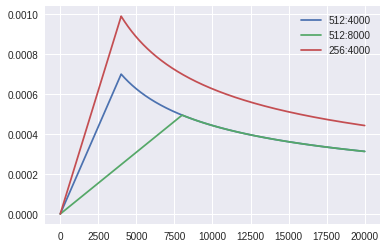

In [0]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

## 正则化

### 标签平滑

在训练中，Alexander等人使用了标签平滑的方法，且平滑值ϵ_ls=0.1。这可能会有损困惑度，因为模型将变得更加不确定它所做的预测，不过这样还是提升了准确度和BLEU分数。

Harvard NLP最终使用KL散度实现了标签平滑，与其使用one-hot目标分布，他们选择了创建一个对正确词有置信度的分布，而其它平滑的概率质量分布将贯穿整个词汇库。


In [0]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

下面，我们可以了解到概率质量如何基于置信度分配到词。

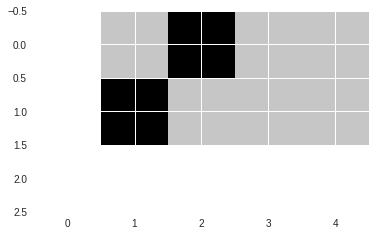

In [0]:
#Example
crit = LabelSmoothing(5, 0, 0.5)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

标签平滑实际上在模型对某些选项非常有信心的时候会惩罚它。

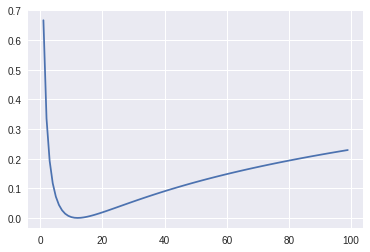

In [0]:
# Label smoothing starts to penalize the model 
# if it gets very confident about a given choice
crit = LabelSmoothing(5, 0, 0.2)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

### 内存优化

In [0]:
def loss_backprop(generator, criterion, out, targets, normalize):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.data[0]
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    out_grad = torch.stack(out_grad, dim=1)
    out.backward(gradient=out_grad)
    return total

In [0]:
def make_std_mask(src, tgt, pad):
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

In [0]:
def train_epoch(train_iter, model, criterion, opt, transpose=False):
    model.train()
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
                        
        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 10 == 1:
            print(i, loss, model_opt._rate)

In [0]:
def valid_epoch(valid_iter, model, criterion, transpose=False):
    model.test()
    total = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = \
            batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens) 
        

In [0]:
class Batch:
    def __init__(self, src, trg, src_mask, trg_mask, ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens
    
def data_gen(V, batch, nbatches):
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        src_mask, tgt_mask = make_std_mask(src, tgt, 0)
        yield Batch(src, tgt, src_mask, tgt_mask, (tgt[1:] != 0).data.sum())

In [0]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = get_std_opt(model)
for epoch in range(2):
    train_epoch(data_gen(V, 30, 20), model, criterion, model_opt)

1 2.9646920561790466 6.987712429686844e-07


KeyboardInterrupt: ignored

# 真实案例
现在，我们将使用IWSLT德语-英语数据集实现翻译任务。该任务要比论文中讨论的WMT任务稍微小一点，但足够展示整个系统。我们同样还展示了如何使用多GPU处理来令加速训练过程。这一部分好像还有一些问题，我们会继续测试并更新到机器之心的GitHub实现项目中。

In [0]:
# For data loading.
from torchtext import data, datasets

In [0]:
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download de

    6% |██                              | 2.4MB 47.2MB/s eta 0:00:01    100% |████████████████████████████████| 37.4MB 50.2MB/s 
  Running setup.py install for en-core-web-sm ... - \ | done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

    100% |████████████████████████████████| 38.2MB 50.0MB/s 
  Running setup.py install for de-core-news-sm ... - \ | done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/de

    You can now load the model via spacy.load('de')



### 数据加载
我们将使用 torchtext 和 spacy 加载数据集，并实现分词。

In [0]:
# Load words from IWSLT

#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

import spacy
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                 eos_token = EOS_WORD, pad_token=BLANK_WORD)

MAX_LEN = 100
train, val, test = datasets.IWSLT.splits(exts=('.de', '.en'), fields=(SRC, TGT), 
                                         filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
MIN_FREQ = 1
SRC.build_vocab(train.src, min_freq=MIN_FREQ)
TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

downloading de-en.tgz
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.de.xml
.data/iwslt/de-en/train.tags.de-en.en
.data/iwslt/de-e

我们希望有非常均匀的批量，且有最小的填充，因此我们必须对默认的torchtext分批函数进行修改。这段代码修改了默认的分批过程，以确保我们能搜索足够的语句以找到紧凑的批量。

### 数据迭代器
迭代器定义了分批过程的多项操作，包括数据清洗、整理和分批等。

In [0]:
# Detail. Batching seems to matter quite a bit. 
# This is temporary code for dynamic batching based on number of tokens.
# This code should all go away once things get merged in this library.

BATCH_SIZE = 4096
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src_mask, trg_mask = make_std_mask(src, trg, pad_idx)
    return Batch(src, trg, src_mask, trg_mask, (trg[1:] != pad_idx).data.sum())

train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

NameError: ignored

In [0]:
# Create the model an load it onto our GPU.
pad_idx = TGT.vocab.stoi["<blank>"]
model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
model_opt = get_std_opt(model)
model.cuda()

AssertionError: ignored

In [0]:

criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch((rebatch(pad_idx, b) for b in train_iter), model, criterion, model_opt)
    valid_epoch((rebatch(pad_idx, b) for b in valid_iter), model, criterion)

1 9.299771845340729 6.987712429686844e-07
11 9.415135336574167 4.192627457812107e-06
21 8.813630282878876 7.686483672655528e-06
31 9.112178653478622 1.118033988749895e-05
41 8.607461810112 1.4674196102342371e-05
51 8.913826749660075 1.8168052317185794e-05
61 8.701497752219439 2.1661908532029216e-05
71 8.373274087905884 2.515576474687264e-05
81 8.454237446188927 2.8649620961716057e-05
91 7.6996782422065735 3.214347717655948e-05
101 8.037408232688904 3.56373333914029e-05
111 7.704962134361267 3.913118960624633e-05
121 7.699015600606799 4.262504582108975e-05
131 7.367554426193237 4.611890203593317e-05
141 7.2071177661418915 4.961275825077659e-05
151 7.106400920893066 5.310661446562001e-05
161 6.804656069725752 5.660047068046343e-05
171 6.390337720513344 6.0094326895306855e-05
181 5.687528342008591 6.358818311015028e-05
191 6.122820109128952 6.70820393249937e-05
201 5.829070374369621 7.057589553983712e-05



OTHER

In [0]:
BOS_WORD = '<s>'
EOS_WORD = '</s>'
BLANK_WORD = "<blank>"
SRC = data.Field()
TGT = data.Field(init_token = BOS_WORD, eos_token = EOS_WORD, pad_token=BLANK_WORD) # only target needs BOS/EOS

MAX_LEN = 100
train = datasets.TranslationDataset(path="/n/home00/srush/Data/baseline-1M_train.tok.shuf", 
                                    exts=('.en', '.fr'),
                                    fields=(SRC, TGT), 
                                    filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
                                         len(vars(x)['trg']) <= MAX_LEN)
SRC.build_vocab(train.src, max_size=50000)
TGT.build_vocab(train.trg, max_size=50000)

In [0]:
pad_idx = TGT.vocab.stoi["<blank>"]
print(pad_idx)
model = make_model(len(SRC.vocab), len(TGT.vocab), pad_idx, N=6)
model_opt = get_opt(model)
model.cuda()

1


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512)
            (1): Linear(in_features=512, out_features=512)
            (2): Linear(in_features=512, out_features=512)
            (3): Linear(in_features=512, out_features=512)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048)
          (w_2): Linear(in_features=2048, out_features=512)
          (dropout): Dropout(p=0.1)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
          (1): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
        )
      )
      (1): EncoderLayer(
        (self_attn): MultiH

In [0]:
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)
    valid_epoch()

In [0]:
print(pad_idx)
print(len(SRC.vocab))

1
50002


In [0]:
torch.save(model, "/n/rush_lab/trans_ipython.pt")

/n/home00/srush/.conda/envs/py3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type EncoderDecoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/n/home00/srush/.conda/envs/py3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/n/home00/srush/.conda/envs/py3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type EncoderLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/n/home00/srush/.conda/envs/py3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type MultiHeadedAttention. It won't be checked f

In [0]:
#weight = torch.ones(len(TGT.vocab))
#weight[pad_idx] = 0
#criterion = nn.NLLLoss(size_average=False, weight=weight.cuda())
criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, label_smoothing=0.1)
criterion.cuda()
for epoch in range(15):
    train_epoch(train_iter, model, criterion, model_opt)

1 3.269582842476666 0.0005377044714644026
101 3.300532897672383 0.0005726430336128369
201 3.3047672072425485 0.0006075815957612711
301 2.7151080842595547 0.0006425201579097052
401 2.6975380268413574 0.0006774587200581396
501 3.051631387323141 0.0007123972822065737
601 2.554425454698503 0.000747335844355008
701 2.6254820519825444 0.0007822744065034422
801 2.868743653933052 0.0008172129686518764
901 2.5978208642918617 0.0008521515308003106
1001 2.5955790174775757 0.0008870900929487448
1101 2.6764775353949517 0.000922028655097179
1201 2.464000296778977 0.0009569672172456132
1301 2.0503073083236814 0.0009919057793940475
1401 2.295472824771423 0.0010268443415424816
1501 2.245281406212598 0.0010617829036909158
1601 2.2577588511630893 0.00109672146583935
1701 2.2232908592559397 0.0011316600279877844
1801 2.357596361427568 0.0011665985901362186
1901 2.121352154412307 0.0012015371522846527
2001 2.5742998471250758 0.001236475714433087
2101 2.2518509055953473 0.0012714142765815214
2201 2.22513266

/n/home00/srush/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: generator 'Iterator.__iter__' raised StopIteration
  


1 1.5940000533591956 0.0009927515780513657
101 1.7524283765815198 0.0009865483707369156
201 1.900138527940726 0.0009804600111146078
301 1.8419977760640904 0.0009744829985071481
401 1.9621913449373096 0.0009686139798247046
501 2.226916428655386 0.0009628497416600543
601 1.7190162097394932 0.0009571872028951208
701 1.8589106332874508 0.0009516234077802563
801 1.8107321247807704 0.000946155519450957
901 1.6531266793608665 0.0009407808138497059
1001 1.4840005157748237 0.0009354966740233614
1101 1.7578403616789728 0.0009303005847689719
1201 1.3920216620899737 0.0009251901276031373
1301 1.6626927084289491 0.0009201629760320567
1401 1.7256765578058548 0.0009152168911012566
1501 1.6049046433763579 0.0009103497172056578
1601 1.6955451717367396 0.000905559378142174
1701 1.6796367820352316 0.0009008438733884249
1801 1.5794002648835885 0.0008962012745924116
1901 1.9637197174597532 0.0008916297222591652
2001 1.4656428614398465 0.0008871274226214399
2101 1.567156056407839 0.0008826926446824871
2201 

In [0]:
1 10.825187489390373 6.987712429686844e-07
101 9.447168171405792 3.56373333914029e-05
201 7.142856806516647 7.057589553983712e-05
301 6.237934365868568 0.00010551445768827134
401 5.762486848048866 0.00014045301983670557
501 5.415792358107865 0.00017539158198513977
601 5.081815680023283 0.000210330144133574
701 4.788327748770826 0.00024526870628200823
801 4.381739928154275 0.0002802072684304424
901 4.55433791608084 0.00031514583057887664
1001 4.911875109748507 0.0003500843927273108
1101 4.0579032292589545 0.0003850229548757451
1201 4.2276234351193125 0.0004199615170241793
1301 3.932735869428143 0.00045490007917261356
1401 3.8179439397063106 0.0004898386413210477
1501 3.3608515430241823 0.000524777203469482
1601 3.832796103321016 0.0005597157656179162
1701 2.907085266895592 0.0005946543277663504
1801 3.5280659823838505 0.0006295928899147847
1901 2.895841649500653 0.0006645314520632189
2001 3.273784235585481 0.000699470014211653
2101 3.181488689899197 0.0007344085763600873
2201 3.4151616653980454 0.0007693471385085215
2301 3.4343731447588652 0.0008042857006569557
2401 3.0505455391539726 0.0008392242628053899
2501 2.8089329147478566 0.0008741628249538242
2601 2.7827929875456903 0.0009091013871022583
2701 2.4428516102489084 0.0009440399492506926
2801 2.4015486147254705 0.0009789785113991267
2901 2.3568112018401735 0.001013917073547561
3001 2.6349758653668687 0.0010488556356959952
3101 2.5981983028614195 0.0010837941978444295
3201 2.666826274838968 0.0011187327599928637
3301 3.0092043554177508 0.0011536713221412978
3401 2.4580375660589198 0.0011886098842897321
3501 2.586465588421561 0.0012235484464381662
3601 2.5663993963389657 0.0012584870085866006
3701 2.9430236657499336 0.0012934255707350347
3801 2.464644919440616 0.001328364132883469
3901 2.7124062888276512 0.0013633026950319032
4001 2.646443709731102 0.0013971932312809247
4101 2.7294750874862075 0.001380057517579748
4201 2.1295202329056337 0.0013635372009002666
4301 2.596563663915731 0.001347596306985731
4401 2.1265982036820787 0.0013322017384983986
4501 2.3880532500334084 0.0013173229858148
4601 2.6129120760888327 0.0013029318725783852
4701 2.2873719420749694 0.001289002331178292
4801 2.4949760700110346 0.0012755102040816328
4901 2.496607314562425 0.001262433067573089
5001 2.1889712483389303 0.0012497500749750088
5101 1.8677761815488338 0.0012374418168536253
5201 2.2992054556962103 0.0012254901960784316
5301 2.664361578106707 0.0012138783159049418
5401 2.705850490485318 0.0012025903795063202
5501 2.581445264921058 0.0011916115995949978
5601 2.2480602325085783 0.0011809281169581616
5701 1.9289666265249252 0.0011705269268863989
5801 2.4863578918157145 0.0011603958126073107
5901 2.632946971571073 0.0011505232849492607
6001 2.496141305891797 0.0011408985275576757
6101 2.6422974687084206 0.0011315113470699342
6201 2.448802186456305 0.0011223521277270118